# Handwritten Digit Classification using CNN (PyTorch)
## Final Project
#### Himanshu Shete (23B0770)

### Objective:
Build and train a CNN to classify MNIST digits using PyTorch, demonstrating understanding of data prep, CNN design, training, and evaluation.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Data Loading and Visualization
We use the MNIST dataset from torchvision. It consists of 70,000 grayscale 28x28 images of handwritten digits (0-9).


In [2]:
# Transformations: Tensor conversion + Normalization + Augmentation
transform_train = transforms.Compose([
    transforms.RandomRotation(10),               # Data augmentation 1
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Data augmentation 2
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load datasets
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform_test)

# Split for validation
train_set, val_set = random_split(train_dataset, [55000, 5000])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 56.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.65MB/s]


#### Why Normalize?
We normalize MNIST images using mean = 0.1307 and std = 0.3081. To speed up training and stabilizes gradients.


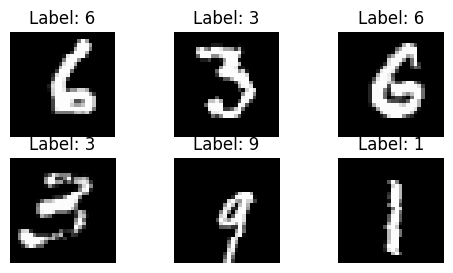

In [3]:
# Visualize a few samples
images, labels = next(iter(train_loader))
plt.figure(figsize=(6, 3))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.show()

### CNN Model Design

We define a CNN with:
- Two convolutional + pooling layers
- One fully connected hidden layer
- Output layer with 10 units (for digits 0-9)


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # (in=1, out=32)
        self.pool1 = nn.MaxPool2d(2, 2)                          # 28x28 → 14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # (32→64)
        self.pool2 = nn.MaxPool2d(2, 2)                          # 14x14 → 7x7
        self.fc1 = nn.Linear(64 * 7 * 7, 128)                   # Fully connected
        self.fc2 = nn.Linear(128, 10)                           # Output layer

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation here; CrossEntropyLoss includes Softmax
        return x

### Training Configuration
We use:
- Loss Function: CrossEntropyLoss (includes Softmax)
- Optimizer: Adam (learning rate = 0.001)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
def train_model(model, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        val_loss, val_acc = evaluate(model, val_loader)
        print(f"Epoch {epoch+1} - Train Acc: {correct/total:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

In [7]:
def evaluate(model, loader):
    model.eval()
    loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return loss / len(loader), correct / total

In [8]:
train_model(model, epochs=10)

Epoch 1 - Train Acc: 0.9173, Val Acc: 0.9662, Val Loss: 0.1160
Epoch 2 - Train Acc: 0.9724, Val Acc: 0.9788, Val Loss: 0.0759
Epoch 3 - Train Acc: 0.9791, Val Acc: 0.9814, Val Loss: 0.0648
Epoch 4 - Train Acc: 0.9819, Val Acc: 0.9836, Val Loss: 0.0526
Epoch 5 - Train Acc: 0.9847, Val Acc: 0.9826, Val Loss: 0.0588
Epoch 6 - Train Acc: 0.9856, Val Acc: 0.9826, Val Loss: 0.0632
Epoch 7 - Train Acc: 0.9875, Val Acc: 0.9864, Val Loss: 0.0521
Epoch 8 - Train Acc: 0.9876, Val Acc: 0.9858, Val Loss: 0.0483
Epoch 9 - Train Acc: 0.9881, Val Acc: 0.9890, Val Loss: 0.0413
Epoch 10 - Train Acc: 0.9887, Val Acc: 0.9892, Val Loss: 0.0391


### Final Evaluation on Test Set


In [11]:
# Final evaluation
train_loss, _ = evaluate(model, train_loader)
val_loss, _ = evaluate(model, val_loader)
test_loss, test_acc = evaluate(model, test_loader)

print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

Final Training Loss: 0.0275
Final Validation Loss: 0.0371
Final Test Accuracy: 0.9933
Final Test Loss: 0.0215


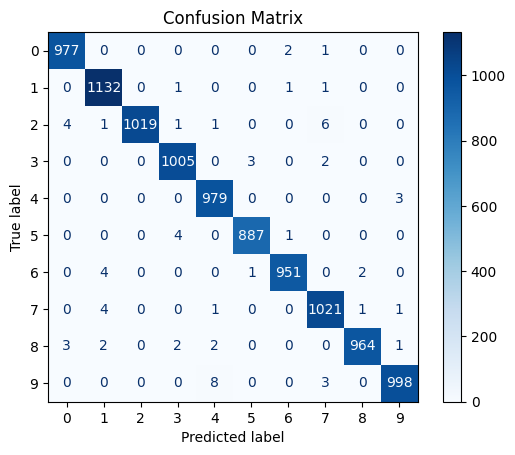

In [12]:
# Confusion matrix
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Analysis and Reflection

### Final Accuracy:
Test Accuracy: 0.9933

### Observations:
- Model sometimes confuses 4 and 9, or 2 and 7 due to similar shapes.
- Data augmentation helped prevent overfitting.

### Challenges:
- Choosing correct normalization values
- Tuning model depth without overfitting

### Future Improvements:
1. Add dropout or batch normalization for better regularization.
2. Use deeper networks like ResNet or train longer with learning rate scheduling.
